In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
import numpy as np
#import time2
import datetime
from sys import getsizeof
import ast
import os
import joblib

!pip install -q -U torch watermark
%reload_ext watermark

!pip install scikit-tensor-py3==0.2.1
from sktensor import dtensor, cp_als

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
%watermark -v -p pandas,numpy,sklearn,matplotlib,seaborn,sktensor

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

pandas    : 1.5.3
numpy     : 1.23.5
sklearn   : 1.2.2
matplotlib: 3.7.1
seaborn   : 0.12.2
sktensor  : 0.2.1



In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


def show_memory(unit='MB', threshold='MB'):
    '''check memory usage

    :param unit: memory unit, `B`,`KB`,`MB`,`GB`
    :param threshold: only show memory usage greater than the threshold
    '''

    scale = {'B': 1, 'KB': 1024, 'MB': 1048576, 'GB': 1073741824}
    for i in list(globals().keys()):
        memory = eval('getsizeof({})'.format(i))
        if memory >= scale[threshold]:
            print(i, str(memory//scale[unit]) + ' ' + unit)

# 3. Load Data

In [ ]:
# Read data

file_path_train = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/TRAIN_DATA.csv'
file_path_test = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/TEST_DATA.csv'

train_df = pd.read_csv(file_path_train)
test_df = pd.read_csv(file_path_test)

data_df = pd.concat([train_df, test_df], ignore_index=True)

data_df.head(1)

,id,userId,gender,sport,duration,calories,distance,avg_heart_rate,longitude,latitude,...,validate,avg_alti,change_alti,max_alti,min_alti,diff_alti,avg_speed,Cluster,route,route_id
0,321096209,9422215,male,run,4562,707.0,12.32541,142.808,"[-51.2151208, -51.2150449, -51.2148496, -51.21...","[-23.3441176, -23.3441733, -23.3443335, -23.34...",...,True,557.1204,264.0,582.0,544.2,37.8,9.792181,5,"('run', '5')",4


In [ ]:
print(data_df.shape)
show_memory()

(66317, 28)
train_df 2630 MB
test_df 657 MB
data_df 3287 MB


In [ ]:
# sequence data was stored in string formatted list
# convert sequence data to array

def str_to_arr(str_ls):
    return np.fromstring(str_ls[1:-1], dtype=np.float, sep=',')


start = time.time()

data_df['heart_rate'] = data_df.apply(
    lambda x: str_to_arr(x['heart_rate']), axis=1)
data_df['altitude'] = data_df.apply(
    lambda x: str_to_arr(x['altitude']), axis=1)
data_df['derived_speed'] = data_df.apply(
    lambda x: str_to_arr(x['derived_speed']), axis=1)
data_df['derived_distance'] = data_df.apply(
    lambda x: str_to_arr(x['derived_distance']), axis=1)
data_df['timestamp'] = data_df.apply(
    lambda x: str_to_arr(x['timestamp']), axis=1)

elapsed = format_time(time.time() - start)
print(elapsed)

data_df.describe()

<ipython-input-10-5d40ecc1fa5c>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.fromstring(str_ls[1:-1], dtype=np.float, sep=',')
<ipython-input-10-5d40ecc1fa5c>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.fromstring(str_ls[1:-1], dtype=np.float, sep=',')
<ipython-input-10-5d40ecc1fa5c>:5: DeprecationWarning: `np

0:00:49


,id,userId,duration,calories,distance,avg_heart_rate,avg_alti,change_alti,max_alti,min_alti,diff_alti,avg_speed,Cluster,route_id
count,6.631700e+04,6.631700e+04,66317.000000,66317.000000,66317.000000,66317.000000,66317.000000,66317.000000,66317.000000,66317.000000,66317.000000,66317.000000,66317.000000,66317.000000
mean,3.690132e+08,4.433191e+06,4226.008670,836.681706,21.121972,141.738083,155.578839,398.531147,191.752579,126.624059,65.128521,17.313001,1.500565,4.424552
std,1.550014e+08,3.854596e+06,2244.057612,519.289536,17.633064,19.193633,256.635738,353.946705,273.798455,246.851079,78.316869,8.251775,1.629714,3.378146
min,1.346435e+06,6.900000e+01,499.000000,100.000000,1.030000,0.000000,-284.491200,0.200000,-261.000000,-500.000000,0.200000,2.006376,0.000000,0.000000
25%,2.650297e+08,1.362730e+06,2654.000000,498.000000,10.000000,132.022000,18.566077,166.200000,40.600000,1.000000,23.600000,10.761971,0.000000,1.000000
50%,3.618274e+08,3.297710e+06,3734.000000,729.000000,14.511780,143.122000,57.689200,285.800000,89.200000,33.000000,43.400000,13.012787,1.000000,4.000000
75%,4.849133e+08,6.692748e+06,5274.000000,1025.000000,26.830000,153.534000,181.166000,510.400000,225.000000,151.200000,74.200000,25.005147,3.000000,7.000000
max,6.675966e+08,1.548142e+07,17848.000000,5733.590000,149.460860,210.194000,1996.081600,2995.600000,2405.200000,1987.400000,999.200000,47.330262,5.000000,18.000000


# 4. Min Max Scaling

In [ ]:
# Load Min-max scaler models

scaler_dic = dict()
features = ['calories', 'distance', 'duration', 'heart_rate',
            'time_elapsed', 'altitude', 'derived_distance', 'speed']

dir = '/content/drive/MyDrive/P3 Fitrec Dataset/scaler/'

for feature in features:
    path = os.path.join(dir, 'scaler_'+feature+'_2.m')
    scaler_dic[feature] = joblib.load(path)
    scaler_dic[feature].clip = False

scaler_dic

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{'calories': MinMaxScaler(),
 'distance': MinMaxScaler(),
 'duration': MinMaxScaler(),
 'heart_rate': MinMaxScaler(),
 'time_elapsed': MinMaxScaler(),
 'altitude': MinMaxScaler(),
 'derived_distance': MinMaxScaler(),
 'speed': MinMaxScaler()}

In [ ]:
sequence_df = data_df[['altitude', 'heart_rate',
                       'derived_distance', 'derived_speed']].copy()
sequence_df.rename(columns={'derived_speed': 'speed'}, inplace=True)

context_df = data_df[['userId', 'gender', 'sport',
                      'duration', 'calories', 'distance', 'route_id']].copy()

display(sequence_df.head(1))
display(context_df.head(1))

,altitude,heart_rate,derived_distance,speed
0,"[581.8, 581.6, 582.0, 581.8, 582.0, 581.8, 581...","[107.0, 107.0, 113.0, 120.0, 130.0, 121.0, 115...","[0.009925036871693787, 0.026748421590752743, 0...","[8.932533184524408, 10.661396583688148, 10.624..."


,userId,gender,sport,duration,calories,distance,route_id
0,9422215,male,run,4562,707.0,12.32541,4


In [ ]:
# Apply min max scaler for each feature

start = time.time()

# for features in sequence_df
for feature in sequence_df.columns:
    # Reshape data using array.reshape(-1, 1) if data has a single feature
    sequence_df[feature] = sequence_df.apply(lambda x: np.concatenate(
        scaler_dic[feature].transform(x[feature].reshape(-1, 1)), axis=0)[0:499], axis=1)

# for features in context_df
for feature in context_df[context_df.columns.difference(['userId',
                                                         'gender',
                                                         'sport',
                                                         'route_id'])].columns:
    # Reshape data using array.reshape(-1, 1) if data has a single feature
    context_df[feature] = scaler_dic[feature].transform(
        context_df[feature].to_numpy().reshape(-1, 1))


elapsed = format_time(time.time() - start)
print(elapsed)

display(sequence_df.head(1))
display(context_df.head(1))

0:02:26


,altitude,heart_rate,derived_distance,speed
0,"[0.3651114206128133, 0.36504178272980503, 0.36...","[0.4458333333333333, 0.4458333333333333, 0.470...","[0.005383502349139231, 0.01450878141120791, 0....","[0.08932678003546661, 0.10661569431971743, 0.1..."


,userId,gender,sport,duration,calories,distance,route_id
0,9422215,male,run,0.255603,0.126953,0.094015,4


In [ ]:
data_df = pd.concat([context_df, sequence_df, data_df[['timestamp']]], axis=1)

data_df.head(1)

,userId,gender,sport,duration,calories,distance,route_id,altitude,heart_rate,derived_distance,speed,timestamp
0,9422215,male,run,0.255603,0.126953,0.094015,4,"[0.3651114206128133, 0.36504178272980503, 0.36...","[0.4458333333333333, 0.4458333333333333, 0.470...","[0.005383502349139231, 0.01450878141120791, 0....","[0.08932678003546661, 0.10661569431971743, 0.1...","[1392876466.0, 1392876470.0, 1392876478.0, 139..."


# 5. Process data to construct User-Workout Route-Context Tensor

In [ ]:
# Construct user profile, which will be used in embedding visualisation

# Count workout numbers and workout frequency for each user

def get_freq_from_ts(ts_list):

    deltas = []

    ts_list.sort()
    for i, ts in enumerate(ts_list):
        if i == 0:
            pass
        else:
            ts_prev = ts_list[i-1]

            dt_prev = datetime.datetime.fromtimestamp(ts_prev).date()
            dt = datetime.datetime.fromtimestamp(ts).date()

            deltas.append(abs(dt-dt_prev).days)
    try:
        if (len(deltas) == 1) & (sum(deltas) == 0):
            return 0
        else:
            return 1./(sum(deltas)/len(deltas))
    except:
        print('deltas: ', deltas)
        raise

start = time.time()

userlist = data_df.userId.unique().tolist()
print('There are {} users.'.format(len(userlist)))

user_profile = []

for user in userlist:
    time_stamps_list = data_df[data_df.userId == user].timestamp.tolist()
    time_stamp_list = [time_stamps[0] for time_stamps in time_stamps_list]
    gender = data_df[data_df.userId == user].gender.iloc[0]
    records = len(time_stamp_list)
    if records > 1:
        user_profile.append([user,
                             records,
                             get_freq_from_ts(time_stamp_list)])
    else:
        user_profile.append([user,
                             1,
                             0])

user_profile_df = pd.DataFrame(user_profile, columns = ['userId',
                                                        'workout_records',
                                                        'workout_freq'])

elapsed = format_time(time.time() - start)
print(elapsed)

user_profile_df.head(1)

There are 936 users.
0:00:02


,userId,workout_records,workout_freq
0,9422215,34,0.114583


In [ ]:
# Compute avg_calories, avg_speed, avg_distance for each user

user_profile_list = []

for user in userlist:

    avg_calories = data_df[data_df.userId == user].calories.mean()
    avg_distance = data_df[data_df.userId == user].distance.mean()
    avg_speed = data_df[data_df.userId == user].apply(
        lambda x: x.speed.mean(), axis=1).mean()

    user_arr = np.array([user,
                         avg_calories,
                         avg_speed,
                         avg_distance])

    user_profile_list.append(user_arr)

user_df = pd.DataFrame(user_profile_list, columns=['userId',
                                                   'avg_calories',
                                                   'avg_speed',
                                                   'avg_distance'])
user_df.head(1)

,userId,avg_calories,avg_speed,avg_distance
0,9422215.0,0.161415,0.106748,0.102227


In [ ]:
# Add additional features to user_profile_df

user_profile_df = user_profile_df.join(
    user_df.set_index('userId'), how='left', on='userId')

user_profile_df.head(1)

,userId,workout_records,workout_freq,avg_calories,avg_speed,avg_distance
0,9422215,34,0.114583,0.161415,0.106748,0.102227


In [ ]:
# Add workout numbers and workout frequency to data_df
start = time.time()

data_df['workout_records'] = data_df.apply(
    lambda x: user_profile_df[user_profile_df.userId == x.userId].workout_records.values[0], axis=1)
data_df['workout_freq'] = data_df.apply(
    lambda x: user_profile_df[user_profile_df.userId == x.userId].workout_freq.values[0], axis=1)

elapsed = format_time(time.time() - start)
print(elapsed)

data_df.head(1)

0:01:00


,userId,gender,sport,duration,calories,distance,route_id,altitude,heart_rate,derived_distance,speed,timestamp,workout_records,workout_freq
0,9422215,male,run,0.255603,0.126953,0.094015,4,"[0.3651114206128133, 0.36504178272980503, 0.36...","[0.4458333333333333, 0.4458333333333333, 0.470...","[0.005383502349139231, 0.01450878141120791, 0....","[0.08932678003546661, 0.10661569431971743, 0.1...","[1392876466.0, 1392876470.0, 1392876478.0, 139...",34,0.114583


In [ ]:
# Scale workout_records and workout_freq

scaler_dic = {}

scaler_workout_records = MinMaxScaler()
scaler_workout_freq = MinMaxScaler()

scaler_workout_records.fit(data_df.workout_records.to_numpy().reshape(-1, 1))
scaler_workout_freq.fit(data_df.workout_freq.to_numpy().reshape(-1, 1))

data_df['workout_records'] = scaler_workout_records.transform(
    data_df.workout_records.to_numpy().reshape(-1, 1)).reshape(1, -1)[0]
data_df['workout_freq'] = scaler_workout_freq.transform(
    data_df.workout_freq.to_numpy().reshape(-1, 1)).reshape(1, -1)[0]

In [ ]:
# Compute some parameters from sequence data

start = time.time()

data_df['min_altitude'] = data_df.apply(lambda x: np.amin(x.altitude), axis=1)
data_df['avg_altitude'] = data_df.apply(lambda x: x.altitude.mean(), axis=1)
data_df['max_altitude'] = data_df.apply(lambda x: np.amax(x.altitude), axis=1)

data_df['min_heart_rate'] = data_df.apply(
    lambda x: np.amin(x.heart_rate), axis=1)
data_df['avg_heart_rate'] = data_df.apply(
    lambda x: x.heart_rate.mean(), axis=1)
data_df['max_heart_rate'] = data_df.apply(
    lambda x: np.amax(x.heart_rate), axis=1)

data_df['min_distance'] = data_df.apply(
    lambda x: np.amin(x.derived_distance), axis=1)
data_df['avg_distance'] = data_df.apply(
    lambda x: x.derived_distance.mean(), axis=1)
data_df['max_distance'] = data_df.apply(
    lambda x: np.amax(x.derived_distance), axis=1)

data_df['min_speed'] = data_df.apply(lambda x: np.amin(x.speed), axis=1)
data_df['avg_speed'] = data_df.apply(lambda x: x.speed.mean(), axis=1)
data_df['max_speed'] = data_df.apply(lambda x: np.amax(x.speed), axis=1)

elapsed = format_time(time.time() - start)
print(elapsed)

0:00:14


In [ ]:
# Construct route profile, which will be used in embedding visualisation

route_list = data_df.route_id.unique()
route_profile_list = []

for route in route_list:
    tmp_df = data_df[data_df.route_id == route].copy()
    avg_distance_route = tmp_df.avg_distance.mean()
    avg_speed_route = tmp_df.avg_speed.mean()
    avg_calories_route = tmp_df.calories.mean()
    sport = tmp_df.sport.iloc[0]

    route_arr = np.array([route,
                          sport,
                          avg_calories_route,
                          avg_speed_route,
                          avg_distance_route])

    route_profile_list.append(route_arr)

route_profile_df = pd.DataFrame(route_profile_list, columns=['route_id',
                                                             'sport',
                                                             'avg_calories',
                                                             'avg_speed',
                                                             'avg_distance'])

route_profile_df['route_id'] = route_profile_df['route_id'].astype(int)
route_profile_df[['avg_calories', 'avg_speed', 'avg_distance']] = route_profile_df[[
    'avg_calories', 'avg_speed', 'avg_distance']].apply(pd.to_numeric)
route_profile_df.head(1)

,route_id,sport,avg_calories,avg_speed,avg_distance
0,4,run,0.136087,0.111098,0.011969


In [ ]:
# Encode gender feature

conditions = [
    (data_df['gender'] == 'male'),
    (data_df['gender'] == 'female'),
    (data_df['gender'] == 'unknown')]

choices = [0, 1, 2]

data_df['genderId'] = np.select(conditions, choices, default=0)

In [ ]:
# Encode sport feature

conditions = [
    (data_df['sport'] == 'run'),
    (data_df['sport'] == 'bike'),
    (data_df['sport'] == 'mountain bike')]

choices = [0, 1, 2]

data_df['sportId'] = np.select(conditions, choices, default=0)

In [ ]:
data_df.head(1)

,userId,gender,sport,duration,calories,distance,route_id,altitude,heart_rate,derived_distance,...,avg_heart_rate,max_heart_rate,min_distance,avg_distance,max_distance,min_speed,avg_speed,max_speed,genderId,sportId
0,9422215,male,run,0.255603,0.126953,0.094015,4,"[0.3651114206128133, 0.36504178272980503, 0.36...","[0.4458333333333333, 0.4458333333333333, 0.470...","[0.005383502349139231, 0.01450878141120791, 0....",...,0.594915,0.791667,0.000852,0.01332,0.038164,0.036095,0.097923,0.157388,0,0


In [ ]:
# Compute user - workout route - context tensor

user_list = data_df.userId.unique()


start = time.time()

users_routes_list = []
route_idx = {}

for route in route_list:
    route_idx[route] = data_df[data_df.route_id == route].sport.tolist()[0]

# # mask array for tensor decomposition
#     # array of booleans with the same shape as tensor
#     # 0 where the values are missing and 1 everywhere else
# mask_arr = np.ones((len(user_list), len(route_list), 13))

for i, user in enumerate(user_list):
    user_records = data_df[data_df.userId == user].shape[0]
    user_routes_list = []

    for j, route in enumerate(route_list):

        user_route_df = data_df[(data_df.userId == user) & (
            data_df.route_id == route)].copy()
        # if this user has more than one workout in this route
        if user_route_df.shape[0] > 0:

            user_gender = user_route_df.genderId.tolist()[0]
            sport = user_route_df.sportId.tolist()[0]
            workout_records = user_route_df.workout_records.tolist()[0]
            workout_freq = user_route_df.workout_freq.tolist()[0]

            cw_min_duration = user_route_df.duration.min()
            cw_avg_duration = user_route_df.duration.mean()
            cw_max_duration = user_route_df.duration.max()

            cw_min_calories = user_route_df.calories.min()
            cw_avg_calories = user_route_df.calories.mean()
            cw_max_calories = user_route_df.calories.max()

            cw_min_distance = user_route_df.distance.min()
            cw_avg_distance = user_route_df.distance.mean()
            cw_max_distance = user_route_df.distance.max()

            cw_min_min_altitude = user_route_df.min_altitude.min()
            cw_avg_min_altitude = user_route_df.min_altitude.mean()
            cw_max_min_altitude = user_route_df.min_altitude.max()

            cw_min_avg_altitude = user_route_df.avg_altitude.min()
            cw_avg_avg_altitude = user_route_df.avg_altitude.mean()
            cw_max_avg_altitude = user_route_df.avg_altitude.max()

            cw_min_max_altitude = user_route_df.max_altitude.min()
            cw_avg_max_altitude = user_route_df.max_altitude.mean()
            cw_max_max_altitude = user_route_df.max_altitude.max()

            cw_min_min_heart_rate = user_route_df.min_heart_rate.min()
            cw_avg_min_heart_rate = user_route_df.min_heart_rate.mean()
            cw_max_min_heart_rate = user_route_df.min_heart_rate.max()

            cw_min_avg_heart_rate = user_route_df.avg_heart_rate.min()
            cw_avg_avg_heart_rate = user_route_df.avg_heart_rate.mean()
            cw_max_avg_heart_rate = user_route_df.avg_heart_rate.max()

            cw_min_max_heart_rate = user_route_df.max_heart_rate.min()
            cw_avg_max_heart_rate = user_route_df.max_heart_rate.mean()
            cw_max_max_heart_rate = user_route_df.max_heart_rate.max()

            cw_min_min_distance = user_route_df.min_distance.min()
            cw_avg_min_distance = user_route_df.min_distance.mean()
            cw_max_min_distance = user_route_df.min_distance.max()

            cw_min_avg_distance = user_route_df.avg_distance.min()
            cw_avg_avg_distance = user_route_df.avg_distance.mean()
            cw_max_avg_distance = user_route_df.avg_distance.max()

            cw_min_max_distance = user_route_df.max_distance.min()
            cw_avg_max_distance = user_route_df.max_distance.mean()
            cw_max_max_distance = user_route_df.max_distance.max()

            cw_min_min_speed = user_route_df.min_speed.min()
            cw_avg_min_speed = user_route_df.min_speed.mean()
            cw_max_min_speed = user_route_df.min_speed.max()

            cw_min_avg_speed = user_route_df.avg_speed.min()
            cw_avg_avg_speed = user_route_df.avg_speed.mean()
            cw_max_avg_speed = user_route_df.avg_speed.max()

            cw_min_max_speed = user_route_df.max_speed.min()
            cw_avg_max_speed = user_route_df.max_speed.mean()
            cw_max_max_speed = user_route_df.max_speed.max()

            # proportion of this route in all workout route records of this user
            cw_route_weight = user_route_df.shape[0]/user_records

            user_route_arr = np.array([user_gender,
                                       sport,
                                       workout_records,
                                       workout_freq,
                                       cw_min_duration,
                                       cw_avg_duration,
                                       cw_max_duration,
                                       cw_min_calories,
                                       cw_avg_calories,
                                       cw_max_calories,
                                       cw_min_distance,
                                       cw_avg_distance,
                                       cw_max_distance,
                                       cw_min_min_altitude,
                                       cw_avg_min_altitude,
                                       cw_max_min_altitude,
                                       cw_min_avg_altitude,
                                       cw_avg_avg_altitude,
                                       cw_max_avg_altitude,
                                       cw_min_max_altitude,
                                       cw_avg_max_altitude,
                                       cw_max_max_altitude,
                                       cw_min_min_heart_rate,
                                       cw_avg_min_heart_rate,
                                       cw_max_min_heart_rate,
                                       cw_min_avg_heart_rate,
                                       cw_avg_avg_heart_rate,
                                       cw_max_avg_heart_rate,
                                       cw_min_max_heart_rate,
                                       cw_avg_max_heart_rate,
                                       cw_max_max_heart_rate,
                                       cw_min_min_distance,
                                       cw_avg_min_distance,
                                       cw_max_min_distance,
                                       cw_min_avg_distance,
                                       cw_avg_avg_distance,
                                       cw_max_avg_distance,
                                       cw_min_max_distance,
                                       cw_avg_max_distance,
                                       cw_max_max_distance,
                                       cw_min_min_speed,
                                       cw_avg_min_speed,
                                       cw_max_min_speed,
                                       cw_min_avg_speed,
                                       cw_avg_avg_speed,
                                       cw_max_avg_speed,
                                       cw_min_max_speed,
                                       cw_avg_max_speed,
                                       cw_max_max_speed,
                                       cw_route_weight])
        else:
            user_route_arr = np.zeros([50])
            # mask_arr[i][j] = np.zeros([50])

        user_routes_list.append(user_route_arr)

    user_routes_arr = np.stack(user_routes_list, axis=0)
    users_routes_list.append(user_routes_arr)

users_routes_arr = np.stack(users_routes_list, axis=0)

elapsed = format_time(time.time() - start)
print(elapsed)

0:00:26


# 6. CP Decomposition

## 6.1 Define function to perform CP Decomposition and evaluate number of CP ranks

The theories of CORCONDIA and Efficient CORCONDIA algorithms in this section are referenced from

1. Bro, R. and Kiers, H.A.L. (2003), A new efficient method for determining the number of components in PARAFAC models. J. Chemometrics, 17: 274-286. doi:10.1002/cem.801.

2. E. E. Papalexakis and C. Faloutsos, "Fast efficient and scalable Core Consistency Diagnostic for the parafac decomposition for big sparse tensors," 2015 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Brisbane, QLD, 2015, pp. 5441-5445, doi: 10.1109/ICASSP.2015.7179011.

3. Anna Sapienza (2017). Tensor decomposition techniques for analysing time-varying networks. Available at : http://porto.polito.it/2668112/. doi:10.6092/polito/porto/2668112.

**Core Consistency Diagnostic (CORCONDIA):**


CP Decomposition for a three-way tensor $\mathcal{X} \in \mathbb{R}^{I \times J \times K}$ can be represented as

$$
\mathcal{X}=[[ \mathbf{A}, \mathbf{B}, \mathbf{C} ]]+\mathcal{E}
$$

that can be written in the matricised form

$$
\mathrm{X}=\mathrm{A}(\mathrm{C} \odot \mathrm{B})^{T}+\mathrm{E}
$$

where

* $X \in \mathbb{R}^{I \times JK}$: Original tensor to be decomposed in matrix form
* $A \in \mathbb{R}^{I \times R}$: Can be seen as the user matrix after CP Decomposition
* $B \in \mathbb{R}^{J \times R}$: Can be seen as the route matrix after CP Decomposition
* $C \in \mathbb{R}^{K \times R}$: Can be seen as the contextual feature matrix after CP Decomposition
* $E \in \mathbb{R}^{I \times JK}$: Decomposition Error

To compute the core consistency value we first re-write the above equation as a Tucker3 model by adding a superdiagonal core tensor $\mathcal{L} \in \mathbb{R}^{R \times R \times R}$ with superdiagonal values of **ones** in its matricised form $\mathbf{L} \in \mathbb{R}^{R \times R R}$:

$$
\mathrm{X}=\mathrm{A} \mathbf{L} (\mathrm{C} \odot \mathrm{B})^{T}+\mathrm{E}
$$

Let's assume we have done the CP Decomposition with selected rank and learned matrices $\mathrm{A}$, $\mathrm{B}$ and $\mathrm{C}$. Then we fit the full Tucker3 model to the data by using the CP Decomposition matrices $\mathrm{A}$, $\mathrm{B}$ and $\mathrm{C}$, by minimising

$$
\sigma(\mathbf{G})=\left\|\mathbf{X}-\mathbf{A G}(\mathbf{C} \otimes \mathbf{B})^{\mathrm{T}}\right\|_{\mathrm{F}}^{2}
$$

over core matrix $\mathbf{G}$. This is essentially saying the residual decomposition error $\sigma(\mathbf{G})$ is minimised.

The optimal $\mathbf{G}$ can be computed by writing the equation in its vectorised form and applying a least squares algorithm

$$
\sigma(\mathbf{G})=\|\operatorname{vec} \mathbf{X}-(\mathbf{C} \otimes \mathbf{B} \otimes \mathbf{A}) \operatorname{vec} \mathbf{G}\|_{F}^{2}
$$

where $\otimes$ is **Kronecker product** (https://en.wikipedia.org/wiki/Kronecker_product).

The optimal $\mathbf{G}$ in the above equation can be determined as

$$
\operatorname{vec} \mathbf{G}=(\mathbf{C} \otimes \mathbf{B} \otimes \mathbf{A})^{+} \operatorname{vec} \mathbf{X}
$$

when the residual decomposition error $\sigma(\mathbf{G})$ is minimised. Note that the superscript $+$ indicates a pseudoinverse.

The underlying idea is to find the similarity between $\mathcal{L}$ and $\mathcal{G}$ where $\mathcal{L}$ is a superdiagonal core tensor that all its superdiagonal values are 1 and all its off-superdiagonal values are 0. To compare the similarity, we can have a look at the distribution of the elements in the superdiagonal and off-superdiagonal of $\mathcal{G}$. If the superdiagonal elements of $\mathcal{G}$ are all close to the corresponding elements of $\mathcal{L}$, which is 1, and the off-superdiagonal elements of of $\mathcal{G}$ are all close to the corresponding elements of $\mathcal{L}$, which is 0, then we say the CP Decomposition result is appropriate.

Formally, the similarity between $\mathcal{L}$ and $\mathcal{G}$, or **`core consistency`** is given by

$$
c c=100\left(1-\frac{\sum{_{l=1}^{R}} \sum{_{m=1}^{R}} \sum{_{n=1}^{R}}\left(g_{l m n}-\lambda_{l m n}\right)^{2}}{R}\right)
$$

**Efficient Core Consistency (Efficient CORCONDIA):**

A faster way to compute the pseudo-inverse $(\mathbf{C} \otimes \mathbf{B} \otimes \mathbf{A})^{+}$ is

$$
\left(\mathbf{V}_{a} \otimes \mathbf{V}_{b} \otimes \mathbf{V}_{c}\right)\left(\Sigma_{a}^{-1} \otimes \Sigma_{b}^{-1} \otimes \Sigma_{c}^{-1}\right)\left(\mathbf{U}_{a}^{T} \otimes \mathbf{U}_{b}^{T} \otimes \mathbf{U}_{c}^{T}\right)
$$

by performing $SVD$ where

* $\mathbf{A} = \mathbf{U}_{a} \Sigma_{a} \mathbf{V}_{a}^T$
* $\mathbf{B} = \mathbf{U}_{b} \Sigma_{b} \mathbf{V}_{b}^T$
* $\mathbf{C} = \mathbf{U}_{c} \Sigma_{c} \mathbf{V}_{c}^T$

Therefore, we have

$$
\operatorname{vec} \mathbf{G}=\left(\mathbf{V}_{a} \otimes \mathbf{V}_{b} \otimes \mathbf{V}_{c}\right)\left(\Sigma_{a}^{-1} \otimes \Sigma_{b}^{-1} \otimes \Sigma_{c}^{-1}\right)\left(\mathbf{U}_{a}^{T} \otimes \mathbf{U}_{b}^{T} \otimes \mathbf{U}_{c}^{T}\right) \operatorname{vec} \mathbf{X}
$$

This section of code was largely borrowed from https://github.com/alessandrobessi/corcondia

In [ ]:
def kronecker(matrices, tensor):
    K = len(matrices)
    x = tensor
    for k in range(K):
        M = matrices[k]
        # sktensor.core.ttm: Tensor times matrix product
        x = x.ttm(M, k)
    return x


def cp_with_eff_corcondia(tensor, num_comp=1):
    '''
    Parameters
    ----------
    num_comp: number of CP Decomposition components
    tensor: tensor to be decomposed
    '''

    # perfrom CP Decomposition
    kruskal_tensor, _,_,_ = cp_als(dtensor(tensor), num_comp, init='random')

    A = kruskal_tensor.U[0]
    B = kruskal_tensor.U[1]
    C = kruskal_tensor.U[2]

    # original tensor
    x = kruskal_tensor.totensor()

    # Compute Core array G with Efficient Core Consistency (efficient CORCONDIA)

    # 1. Singular Value Decomposition of the paramater matrices
    Ua, Sigma_a, Va = np.linalg.svd(A)
    Ub, Sigma_b, Vb = np.linalg.svd(B)
    Uc, Sigma_c, Vc = np.linalg.svd(C)

    # 2. Compute Pseudo-inverse of Sigma
    Sigma_a_Inverse = np.zeros((Ua.shape[0], Va.shape[0]), float)
    np.fill_diagonal(Sigma_a_Inverse, Sigma_a)

    Sigma_b_Inverse = np.zeros((Ub.shape[0], Vb.shape[0]), float)
    np.fill_diagonal(Sigma_b_Inverse, Sigma_b)

    Sigma_c_Inverse = np.zeros((Uc.shape[0], Vc.shape[0]), float)
    np.fill_diagonal(Sigma_c_Inverse, Sigma_c)

    Sigma_a_Inverse = np.linalg.pinv(Sigma_a_Inverse)
    Sigma_b_Inverse = np.linalg.pinv(Sigma_b_Inverse)
    Sigma_c_Inverse = np.linalg.pinv(Sigma_c_Inverse)

    # 3. Computer Core Matrix G
    y = kronecker([Ua.transpose(), Ub.transpose(), Uc.transpose()], x)
    z = kronecker([Sigma_a_Inverse, Sigma_b_Inverse, Sigma_c_Inverse], y)
    G = kronecker([Va.transpose(), Vb.transpose(), Vc.transpose()], z)

    # Compute Core Consistency

    # 1. Construct L (superdiagonal array of ones and off-superdiagonal of zeros)

    L = np.full((num_comp, num_comp, num_comp), 0)
    for i in range(num_comp):
        for j in range(num_comp):
            for l in range(num_comp):
                if i == j == l:
                    L[i][j][l] = 1

    # 2. Compute G subtract L

    c = 0
    for i in range(num_comp):
        for j in range(num_comp):
            for l in range(num_comp):
                c += float(G[i][j][l] - L[i][j][l]) ** 2.0

    # 3. Compute Core Consistency
    cc = 100 * (1 - (c / float(num_comp)))

    return A, B, C, round(cc)

## 6.2 Evaluate number of CP ranks

### 6.2.1 Core Consistency Plot

In [ ]:
import time

In [ ]:
# Perform CP Decomposition and Core Consistency Computation for various ranks

start = time.time()

np.random.seed(32)

num_comps = np.arange(2, 21)
core_cons = []

for num_comp in num_comps:
    _, _, _, core_consistency = cp_with_eff_corcondia(
        users_routes_arr, num_comp)
    core_cons.append([num_comp, core_consistency])

core_cons = pd.DataFrame(core_cons, columns=['num_comp', 'core_consistency'])
display(core_cons.head(1))

elapsed = format_time(time.time() - start)
print(elapsed)

,num_comp,core_consistency
0,2,77


0:01:44


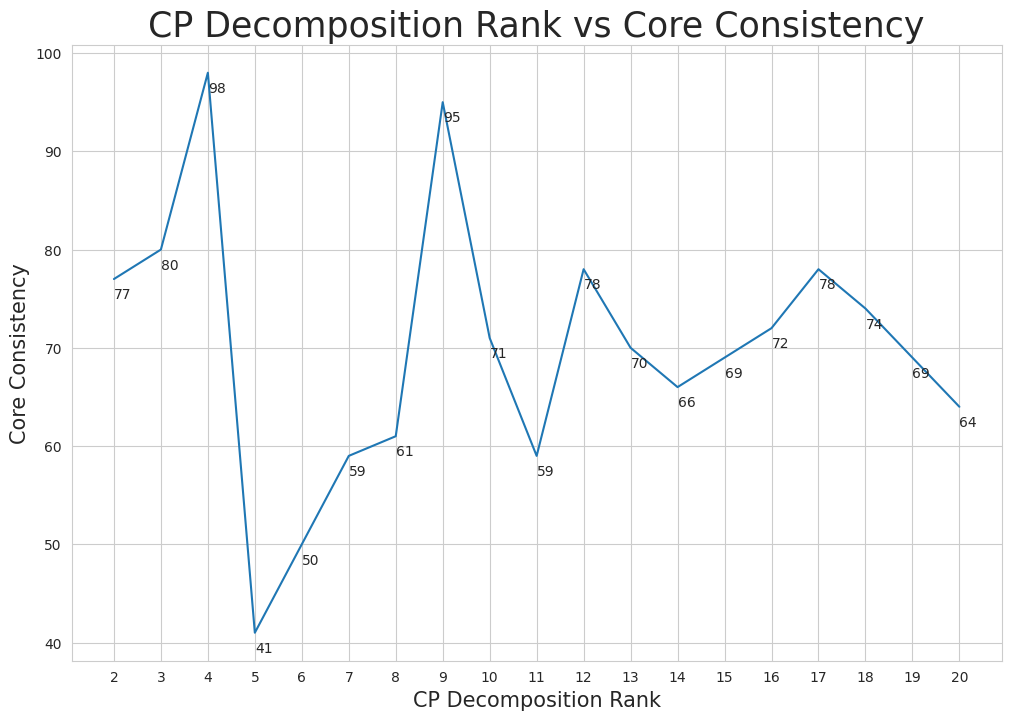

In [ ]:
plt.figure(figsize=(12, 8))

g = sns.lineplot(data=core_cons, x='num_comp', y='core_consistency')

g.axes.set_title('CP Decomposition Rank vs Core Consistency', fontsize=25)

g.set_xlabel('CP Decomposition Rank', fontsize=15)
g.set_ylabel('Core Consistency', fontsize=15)
g.set_xticks(num_comps)
g.set_xticklabels(num_comps)

# label points on the plot
for num_comp, cc in zip(core_cons.num_comp, core_cons.core_consistency):
    plt.text(x=num_comp, y=cc-2, s=cc)

plt.show()

### 6.2.2 T-SNE Plot of Embedding Matrices

In [ ]:
# Create function to visualise both User Embedding and Route Embedding with T-SNE

def embed_visual(profile_df, embed_df, embed_name, perplexity=5):

    if embed_name == 'userEmbed':
        id_col = 'userId'
    elif embed_name == 'routeEmbed':
        id_col = 'route_id'

    tmp_df = profile_df.join(embed_df.set_index(
        id_col), how='left', on=id_col).copy()

    num_comp = embed_df[embed_name][0].shape[0]

    if num_comp == 2:
        tmp_df['component_0'] = tmp_df.apply(
            lambda x: x[embed_name][0], axis=1)
        tmp_df['component_1'] = tmp_df.apply(
            lambda x: x[embed_name][1], axis=1)
        title = embed_name + \
            ' (CP Rank = ' + str(num_comp) + ') Visualisation without T-SNE'
        xlabel = embed_name + ' component_0'
        ylabel = embed_name + ' component_1'

    elif num_comp > 2:
        tsne_obj = TSNE(n_components=2, verbose=0, perplexity=perplexity,
                        n_iter=1000, random_state=15)

        tsne_results = tsne_obj.fit_transform(
            np.stack(tmp_df[embed_name].to_numpy(), axis=0))

        tsne_user_df = pd.DataFrame(data=tsne_results,
                                    index=embed_df[id_col], columns=['component_0', 'component_1'])

        tmp_df = tmp_df.join(tsne_user_df, how='left', on=id_col)

        title = embed_name + \
            ' (CP Rank = ' + str(num_comp) + ') Visualisation with T-SNE'
        xlabel = embed_name + ' T-SNE component_0'
        ylabel = embed_name + ' T-SNE component_1'

    fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi=90)
    fig.suptitle(title, fontsize=20)

    for idx, feat in enumerate(['avg_calories', 'avg_speed', 'avg_distance']):
        if embed_name == 'userEmbed':
            sns.scatterplot(x='component_0',
                            y='component_1',
                            palette=sns.color_palette(
                                'rocket_r', as_cmap=True),
                            data=tmp_df,
                            hue=feat,
                            ax=axes[idx])

        elif embed_name == 'routeEmbed':
            sns.scatterplot(x='component_0',
                            y='component_1',
                            palette='colorblind',
                            size=feat,
                            sizes=(2, 200),
                            data=tmp_df,
                            hue='sport',
                            ax=axes[idx],
                            legend='brief')

    for ax in axes:
        ax.set_xlabel(xlabel, fontsize=15)
        ax.set_ylabel(ylabel, fontsize=15)
        ax.legend(loc='lower left',
                  title=ax.get_legend().get_title().get_text(),
                  fontsize='small')

0:00:47


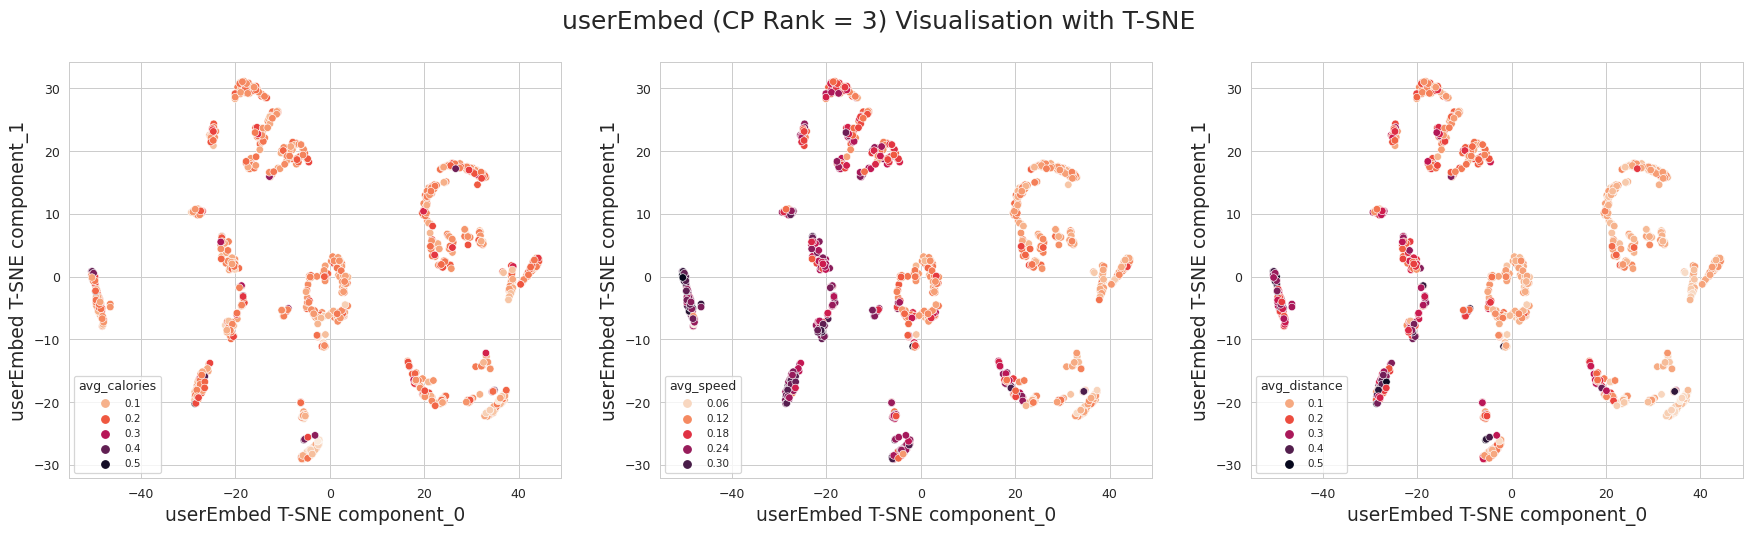

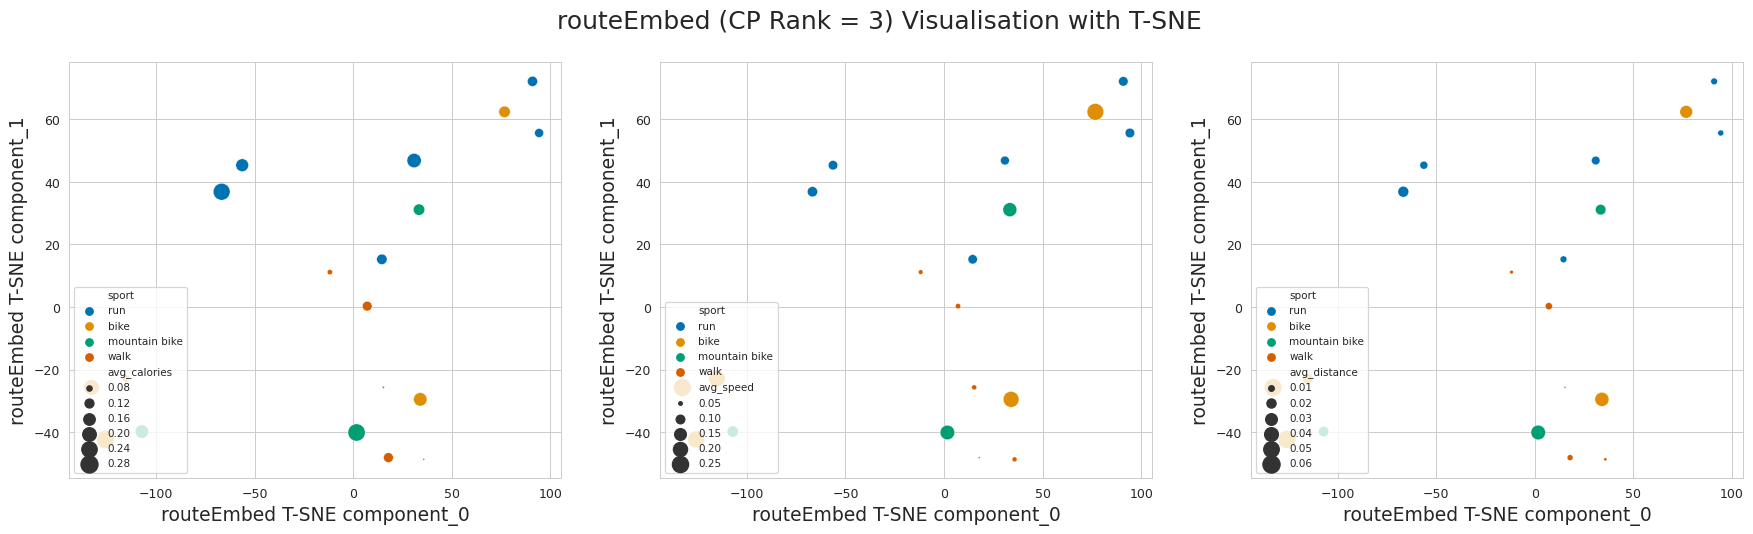

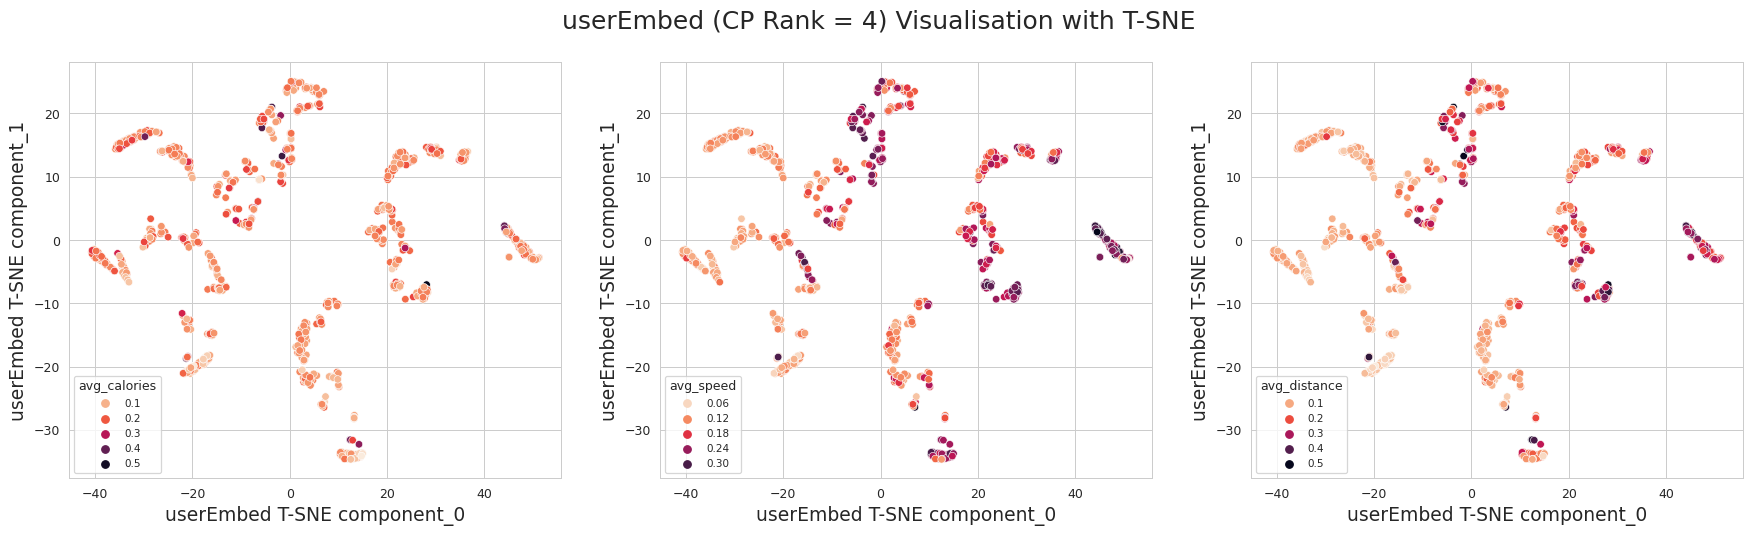

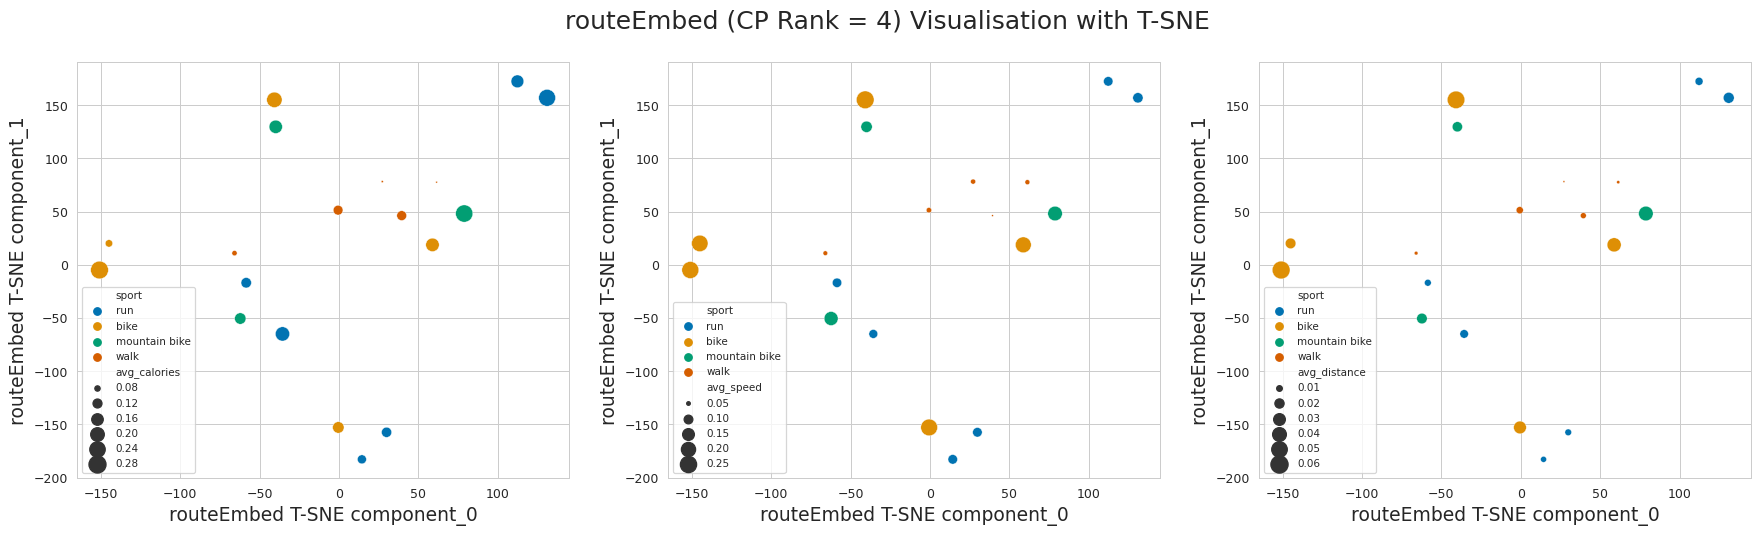

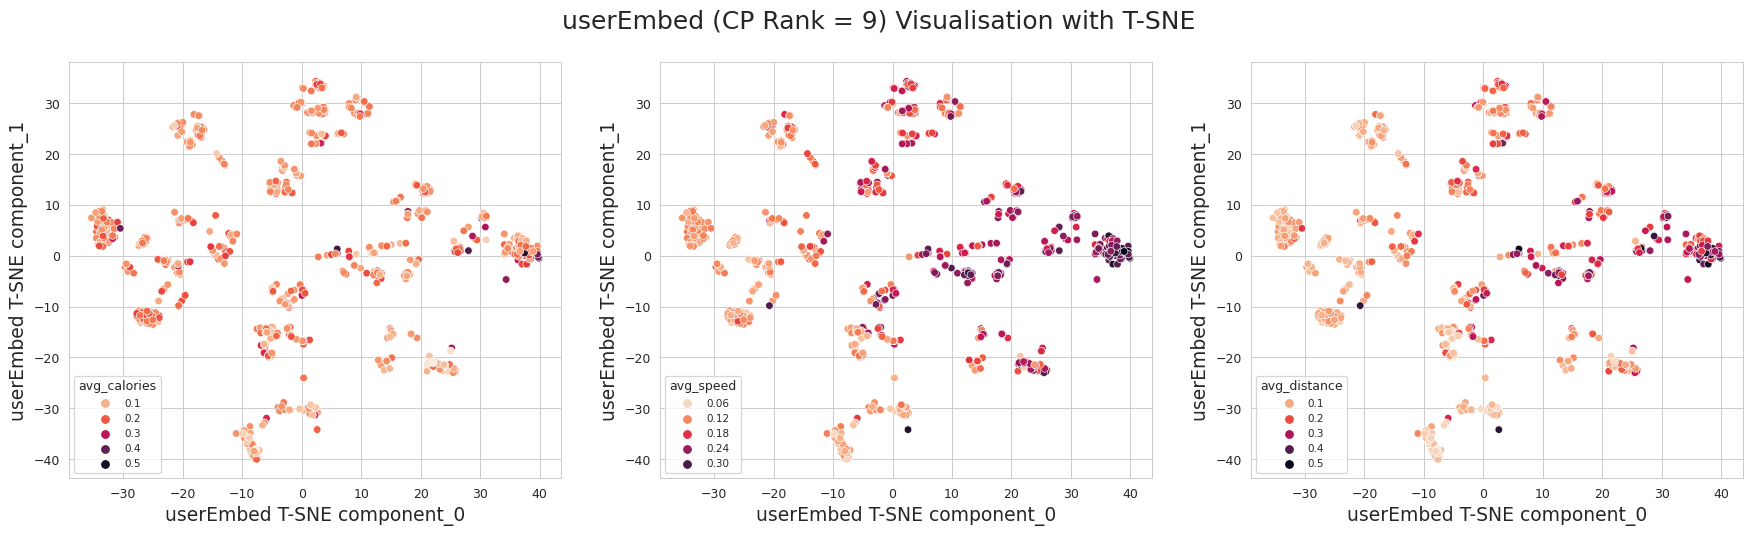

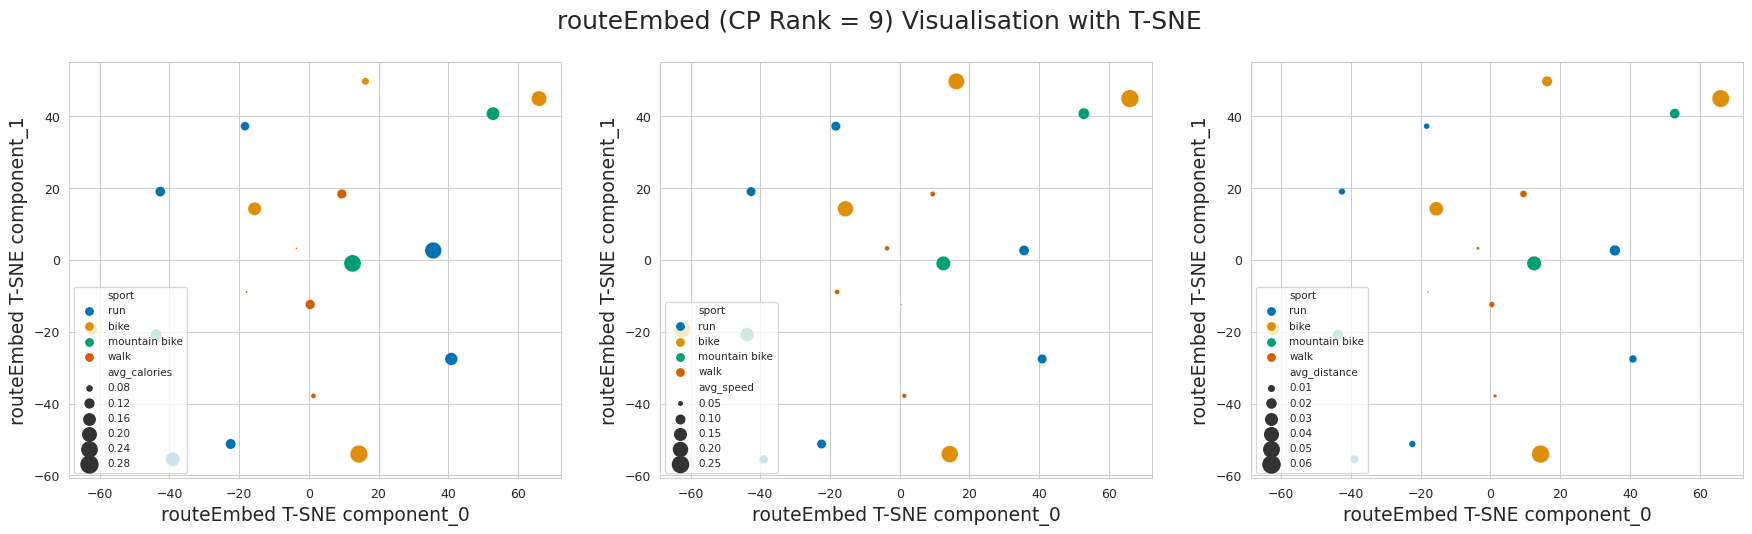

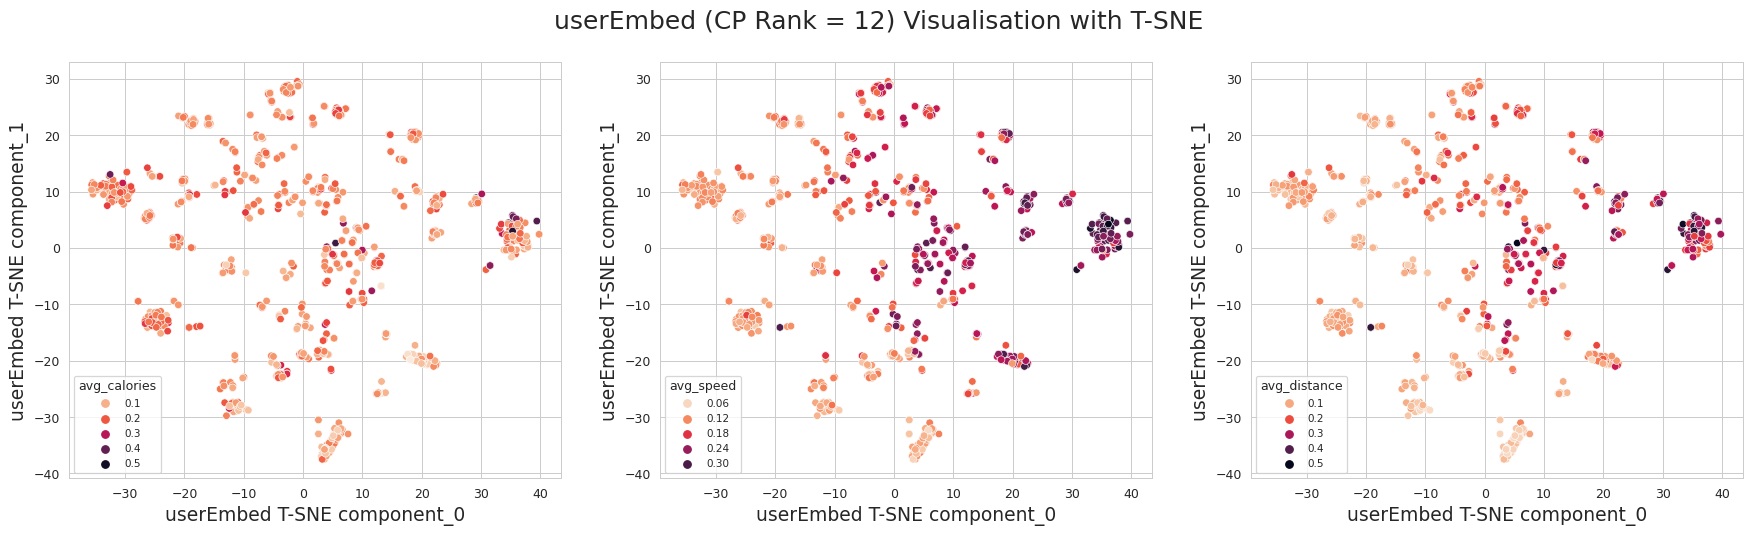

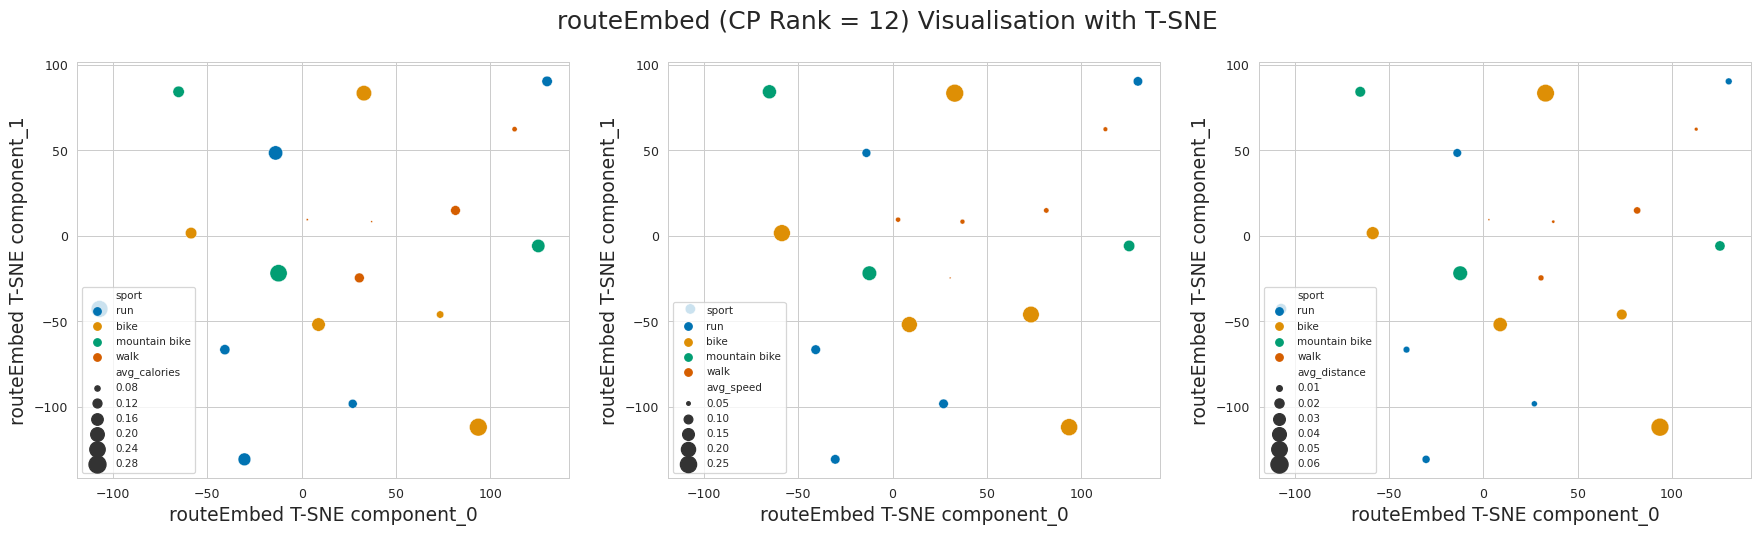

In [ ]:
start = time.time()

num_comps = [3,4,9,12]

for num_comp in num_comps:
    user_matrix, route_matrix, _, _ = cp_with_eff_corcondia(
        users_routes_arr, num_comp)
    user_embed_df = pd.DataFrame(zip(user_list, user_matrix), columns=[
        'userId', 'userEmbed'])

    route_embed_df = data_df[['route_id']].copy()
    route_embed_df.drop_duplicates(inplace=True, ignore_index=True)
    route_embed_df['routeEmbed'] = route_embed_df.apply(
        lambda x: route_matrix[int(x.route_id)], axis=1)

    embed_visual(user_profile_df, user_embed_df, 'userEmbed', perplexity=30)
    embed_visual(route_profile_df, route_embed_df, 'routeEmbed', perplexity=5)

elapsed = format_time(time.time() - start)
print(elapsed)

## 6.3 Save Embeddings

In [ ]:
num_comp = 4

user_matrix, route_matrix, _, _ = cp_with_eff_corcondia(
    users_routes_arr, num_comp)
user_embed_df = pd.DataFrame(zip(user_list, user_matrix), columns=[
    'userId', 'userEmbed'])

route_embed_df = data_df[['route_id']].copy()
route_embed_df.drop_duplicates(inplace=True, ignore_index=True)
route_embed_df['routeEmbed'] = route_embed_df.apply(
    lambda x: route_matrix[int(x.route_id)], axis=1)


# Save Embeddings

userEmbed_file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/user_embedding_4.m'
routeEmbed_file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/route_embedding_4.m'

joblib.dump(user_embed_df, userEmbed_file_path)
joblib.dump(route_embed_df, routeEmbed_file_path)

# Load Embeddings

user_embed_df = joblib.load(userEmbed_file_path)
route_embed_df = joblib.load(routeEmbed_file_path)

In [ ]:
user_embed_df.head(3)

In [ ]:
route_embed_df.head(3)

In [ ]:
num_comp = 9

user_matrix, route_matrix, _, _ = cp_with_eff_corcondia(
    users_routes_arr, num_comp)
user_embed_df = pd.DataFrame(zip(user_list, user_matrix), columns=[
    'userId', 'userEmbed'])

route_embed_df = data_df[['route_id']].copy()
route_embed_df.drop_duplicates(inplace=True, ignore_index=True)
route_embed_df['routeEmbed'] = route_embed_df.apply(
    lambda x: route_matrix[int(x.route_id)], axis=1)


# Save Embeddings

userEmbed_file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/user_embedding_9.m'
routeEmbed_file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/route_embedding_9.m'

joblib.dump(user_embed_df, userEmbed_file_path)
joblib.dump(route_embed_df, routeEmbed_file_path)

# Load Embeddings

user_embed_df = joblib.load(userEmbed_file_path)
route_embed_df = joblib.load(routeEmbed_file_path)

In [ ]:
user_embed_df.head(3)

In [ ]:
route_embed_df.head(3)

In [ ]:
num_comp = 12

user_matrix, route_matrix, _, _ = cp_with_eff_corcondia(
    users_routes_arr, num_comp)
user_embed_df = pd.DataFrame(zip(user_list, user_matrix), columns=[
    'userId', 'userEmbed'])

route_embed_df = data_df[['route_id']].copy()
route_embed_df.drop_duplicates(inplace=True, ignore_index=True)
route_embed_df['routeEmbed'] = route_embed_df.apply(
    lambda x: route_matrix[int(x.route_id)], axis=1)


# Save Embeddings

userEmbed_file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/user_embedding_12.m'
routeEmbed_file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/route_embedding_12.m'

joblib.dump(user_embed_df, userEmbed_file_path)
joblib.dump(route_embed_df, routeEmbed_file_path)

# Load Embeddings

user_embed_df = joblib.load(userEmbed_file_path)
route_embed_df = joblib.load(routeEmbed_file_path)

In [ ]:
num_comp = 17

user_matrix, route_matrix, _, _ = cp_with_eff_corcondia(
    users_routes_arr, num_comp)
user_embed_df = pd.DataFrame(zip(user_list, user_matrix), columns=[
    'userId', 'userEmbed'])

route_embed_df = data_df[['route_id']].copy()
route_embed_df.drop_duplicates(inplace=True, ignore_index=True)
route_embed_df['routeEmbed'] = route_embed_df.apply(
    lambda x: route_matrix[int(x.route_id)], axis=1)


# Save Embeddings

userEmbed_file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/user_embedding_17.m'
routeEmbed_file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/route_embedding_17.m'

joblib.dump(user_embed_df, userEmbed_file_path)
joblib.dump(route_embed_df, routeEmbed_file_path)

# Load Embeddings

user_embed_df = joblib.load(userEmbed_file_path)
route_embed_df = joblib.load(routeEmbed_file_path)

In [ ]:
user_embed_df.head(3)

In [ ]:
route_embed_df.head(3)

In [ ]:
num_comp = 3

user_matrix, route_matrix, _, _ = cp_with_eff_corcondia(
    users_routes_arr, num_comp)
user_embed_df = pd.DataFrame(zip(user_list, user_matrix), columns=[
    'userId', 'userEmbed'])

route_embed_df = data_df[['route_id']].copy()
route_embed_df.drop_duplicates(inplace=True, ignore_index=True)
route_embed_df['routeEmbed'] = route_embed_df.apply(
    lambda x: route_matrix[int(x.route_id)], axis=1)


# Save Embeddings

userEmbed_file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/user_embedding_3.m'
routeEmbed_file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/route_embedding_3.m'

joblib.dump(user_embed_df, userEmbed_file_path)
joblib.dump(route_embed_df, routeEmbed_file_path)

# Load Embeddings

user_embed_df = joblib.load(userEmbed_file_path)
route_embed_df = joblib.load(routeEmbed_file_path)